In [1]:
from neuralprophet import NeuralProphet, set_random_seed
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
#This should lead to identical results every time you run the model. 
# Note that you have to explicitly set the random seed to the same 
# random number each time before fitting the model.
set_random_seed(0)

#visualization
import seaborn as sns
#sns.set_theme()
plt.style.use("seaborn")#use seaborn style
plt.rcParams["lines.linewidth"] = 1.5
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16

#### 1. DATA IMPORT AND MANIPULATION

In [2]:
def prep_data():
    #import data
    df = pd.read_csv("../bergen_florida_temperature_1957-2022.csv",\
                    sep=";", converters={"Tid(norsk normaltid)":str},
                    decimal=",")
    #rename columns
    df.rename(columns={"Tid(norsk normaltid)": "Date", "Middeltemperatur (mnd)": "mean_temp", 
                        "Middeltemperatur, avvik fra normalen 1991-2020 (mnd)": "mean_temp_deviation",
                        "Maksimumstemperatur (mnd)": "max_temp", "Minimumstemperatur (mnd)": "min_temp"}, 
                        inplace=True)

    #seperate month and year from Date column 
    # frm (MM.YYYY) to mm and YYYY
    month = []
    year = []
    for i in range(len(df)):
        month.append( re.findall( r'[0-9]+', str( df["Date"][i] ) ) [0] )
        year.append( re.findall( r'[0-9]+', str( df["Date"][i] ) ) [1] )

    #add month and year list into df 
    df["month"] = month
    df["year"] = year

    #convert month and year into numeric
    df["year"] = df["year"].astype("int")
    df["month"] = df["month"].astype("int")

    #create datatime column using month year
    #and new day column with 1
    df["day"] = "01"
    df["ds"] = pd.to_datetime(dict(year=df.year, month=df.month, day=df.day))#(df[["year", "month", "day"]])
    #copy df for neuralprophet
    df_np = df.copy()
    return df, df_np

df, df_np = prep_data()
df.head()

,Navn,Stasjon,Date,mean_temp,mean_temp_deviation,max_temp,min_temp,month,year,day,ds
0,Bergen - Florida,SN50540,01.1957,3.8,1.2,9.6,-5.0,1,1957,01,1957-01-01
1,Bergen - Florida,SN50540,02.1957,2.3,0.0,9.6,-5.6,2,1957,01,1957-02-01
2,Bergen - Florida,SN50540,03.1957,5.4,1.6,14.5,-2.2,3,1957,01,1957-03-01
3,Bergen - Florida,SN50540,04.1957,6.3,-0.9,14.1,-1.0,4,1957,01,1957-04-01
4,Bergen - Florida,SN50540,05.1957,9.1,-1.6,20.8,1.4,5,1957,01,1957-05-01


#### 2. EXPLORATORY DATA ANALYSIS

In [3]:
df[["mean_temp", "min_temp", "max_temp", "mean_temp_deviation"]].describe()

,mean_temp,min_temp,max_temp,mean_temp_deviation
count,789.000000,789.000000,789.000000,789.000000
mean,8.084664,0.159823,17.101521,-0.326743
std,5.023572,5.681274,6.813043,1.587101
min,-3.400000,-16.300000,4.600000,-6.000000
25%,3.700000,-4.500000,10.600000,-1.400000
50%,7.800000,0.100000,16.600000,-0.300000
75%,12.600000,5.300000,23.100000,0.800000
max,19.600000,11.600000,33.400000,4.200000


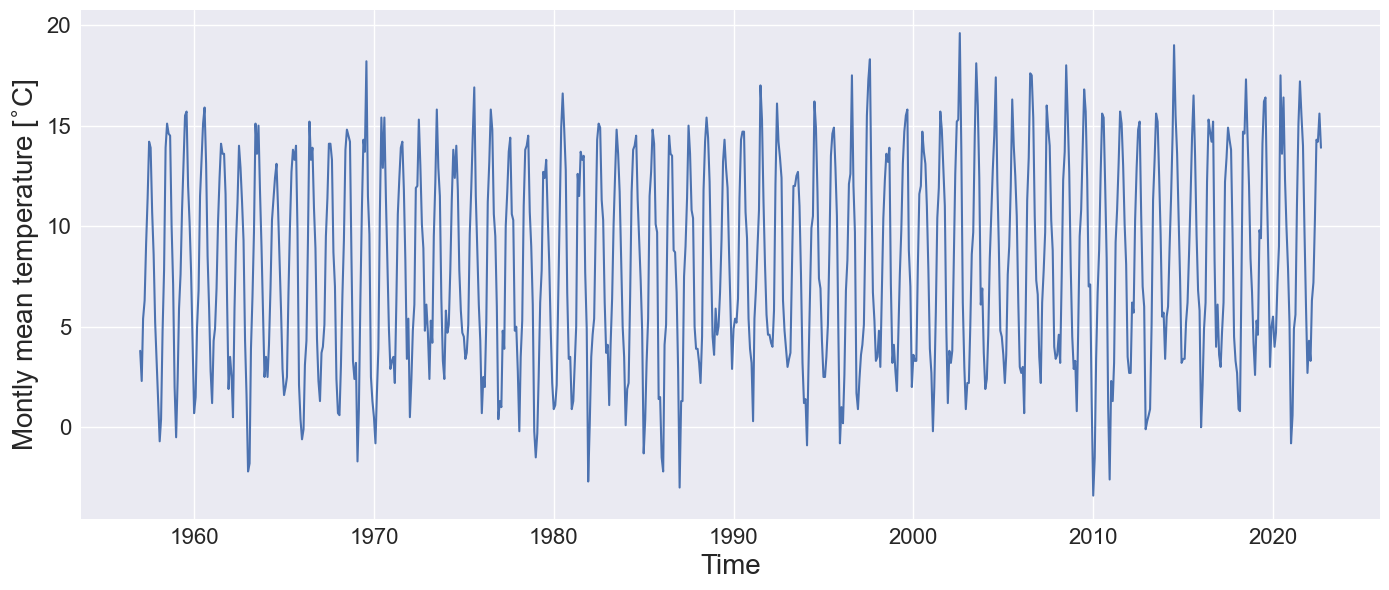

In [4]:
plt.figure(figsize=(14,6))
plt.plot(df["ds"], df["mean_temp"])
plt.xlabel("Time")
plt.ylabel("Montly mean temperature [$^{\circ}$C]")
plt.tight_layout()
plt.show()
#plt.savefig("bergen_mean_temp.pdf")

In [53]:
df=df.set_index("ds")
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 789 entries, 1957-01-01 to 2022-09-01
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Navn                 789 non-null    object 
 1   Stasjon              789 non-null    object 
 2   Date                 789 non-null    object 
 3   mean_temp            789 non-null    float64
 4   mean_temp_deviation  789 non-null    float64
 5   max_temp             789 non-null    float64
 6   min_temp             789 non-null    float64
 7   month                789 non-null    int64  
 8   year                 789 non-null    int64  
 9   day                  789 non-null    object 
dtypes: float64(4), int64(2), object(4)
memory usage: 67.8+ KB


In [ ]:
#groupby montly temperatures
#aggregate np.median and np.std 
qual = (df.groupby
        ("month")["mean_temp"].
        agg([np.median, np.mean, np.std]))
# qual["mean_temp"].plot(kind="bar", 
#                         y="median",
#                         yerr="std",
#                         legend=False)
# plt.ylabel("Temperature averaged over months [$^\circ$C]")
# plt.tight_layout()
# plt.show()
qual

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 789 entries, 0 to 788
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Navn                 789 non-null    object        
 1   Stasjon              789 non-null    object        
 2   Date                 789 non-null    object        
 3   mean_temp            789 non-null    float64       
 4   mean_temp_deviation  789 non-null    float64       
 5   max_temp             789 non-null    float64       
 6   min_temp             789 non-null    float64       
 7   month                789 non-null    int64         
 8   year                 789 non-null    int64         
 9   day                  789 non-null    object        
 10  ds                   789 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(2), object(4)
memory usage: 67.9+ KB


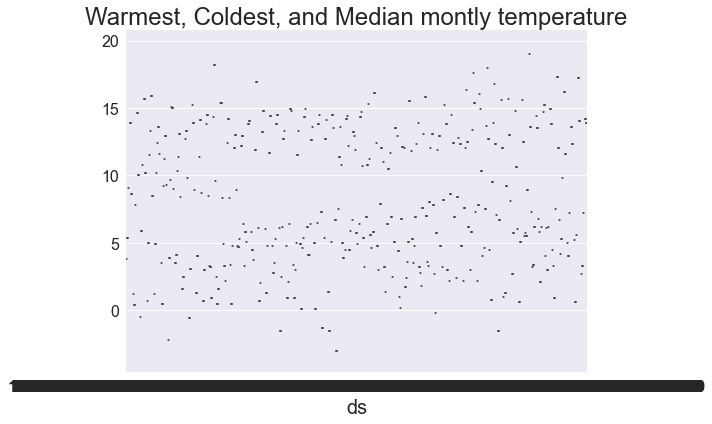

In [69]:
sns.boxplot(x=df["ds"], y="mean_temp", data=df)
plt.ylabel("")
plt.title("Warmest, Coldest, and Median montly temperature")
plt.tight_layout()
plt.show()

Observations:

- December, January, and February are the coldest in a year
- July and August are the hottest in a year
- Overal standard deviations are high 

#### 3. Clustering with Scikit KMeans

In [ ]:
sse = []
target = df["mean_temp"].to_numpy().reshape(-1, 1)
num_clusters = list(range(1, 10))

for k in num_clusters:
     km = make_pipeline(
                         RobustScaler(), 
                         KMeans(n_clusters=k, init="k-means++", random_state=0))
     km.fit(target)
     sse.append(km[-1].inertia_) 

In [ ]:
#plot KMeans clusters
plt.plot(num_clusters, sse, "-o")
plt.title("Evaluation on number of clusters")
plt.xlabel("Number of cluster")
plt.ylabel("Sum of squared distance")
plt.tight_layout()
plt.show()

Observation:

- Cluster size 3 looks like a good choice

In [ ]:
km = make_pipeline(
                    RobustScaler(), 
                     KMeans(3, init="k-means++", random_state=0))
km.fit(target)
df.loc[:, "temp labels"] = km[-1].labels_ 

In [ ]:
km[-1].cluster_centers_

##### Checking normalization using Scikit RobustScaler()

In [ ]:
transformer = RobustScaler().fit(target)
target_val = transformer.transform(target)
plt.plot(df.index, target_val)
plt.title("Normalized temperature with Scikit RobustScaler()")
plt.xlabel("Time")
plt.ylabel("Normalized montly mean temperature [$^\circ$C]")
plt.tight_layout()
plt.show()

In [ ]:
plt.hist(target_val, bins='auto')
plt.title("Normalized temperature histogram with Scikit RobustScaler()")
plt.ylabel("Frequency")
plt.xlabel("Normalized montly mean temperature [$^\circ$C]")
plt.tight_layout()
plt.show()

In [ ]:
#plot temperature clusters
points = plt.scatter(df.index,
                     target_val,#df["mean_temp"], 
                     c=df["temp labels"],
                     cmap="jet", 
                     lw=0)
plt.colorbar(points, label="Cluster temperature labels")
plt.title("Temperature clusters")
plt.xlabel("Time")
plt.ylabel("Montly mean temperature [$^\circ$C]")
plt.tight_layout()
plt.show()

Observations:

- Despite four seasons temperatures clustered in three groups
- 

In [ ]:
type(target_val)

In [ ]:
sns.histplot(x=df["mean_temp"], bins=100, common_norm=True, kde=True)
plt.title("Frequency histogram for temperature")
plt.ylabel("Count")
plt.xlabel("Montly mean temperature [$^\circ$C]")
plt.tight_layout()
plt.show()

#### 4. NEURALPROPHET 

In [3]:
#copy only columns that will be used for forecasting to a new DataFrame
df_np = df_np[["ds", "mean_temp", "max_temp", "min_temp", "mean_temp_deviation"]]
df_np.rename(columns={"mean_temp": "y"}, inplace=True)
df_np.head()

,ds,y,max_temp,min_temp,mean_temp_deviation
0,1957-01-01,3.8,9.6,-5.0,1.2
1,1957-02-01,2.3,9.6,-5.6,0.0
2,1957-03-01,5.4,14.5,-2.2,1.6
3,1957-04-01,6.3,14.1,-1.0,-0.9
4,1957-05-01,9.1,20.8,1.4,-1.6


In [4]:
df2 = df_np[["ds", "y"]]
df2.head()

,ds,y
0,1957-01-01,3.8
1,1957-02-01,2.3
2,1957-03-01,5.4
3,1957-04-01,6.3
4,1957-05-01,9.1


In [5]:
#get forecasting going
m = NeuralProphet(
                    #seasonality_mode= "additive", 
                    #learning_rate = 0.1,
                    seasonality_reg=1, 
                    #trend_reg=1,
                    #n_lags=5,
                    #num_hidden_layers=0,
                    #ar_reg=1,
                    #epochs=500
                    )

#split training and test data
df_train, df_test = m.split_df(df2, freq="MS", valid_p=0.2)
metrics = m.fit(df_train, freq="MS",
                validation_df=df_test)

metrics.tail()

INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 91.508% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 91.456% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 226
 98%|██

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
221,0.003054,1.141328,1.412077,0.000039,0.004570,1.304754,1.759167
222,0.003052,1.140212,1.412397,0.000039,0.004579,1.302799,1.760882
223,0.003044,1.138468,1.412884,0.000039,0.004559,1.300381,1.756951
224,0.003041,1.138252,1.416111,0.000039,0.004547,1.298025,1.754618
225,0.003039,1.137972,1.402803,0.000039,0.004548,1.298225,1.754808


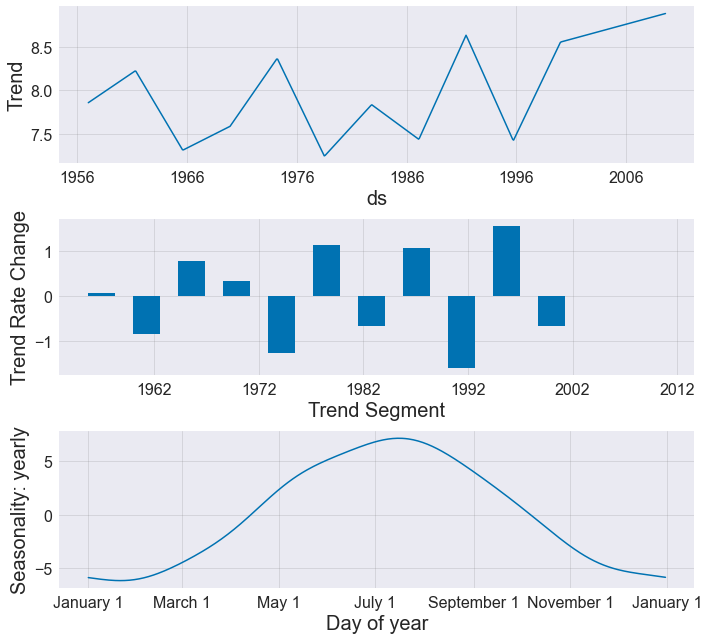

In [6]:
fig_par = m.plot_parameters()

In [7]:
#prediction dataframe
future = m.make_future_dataframe(df2, periods=12, n_historic_predictions=len(df2))
forecast = m.predict(future)

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 91.508% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 91.511% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 91.511% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS


In [ ]:
forecast.columns

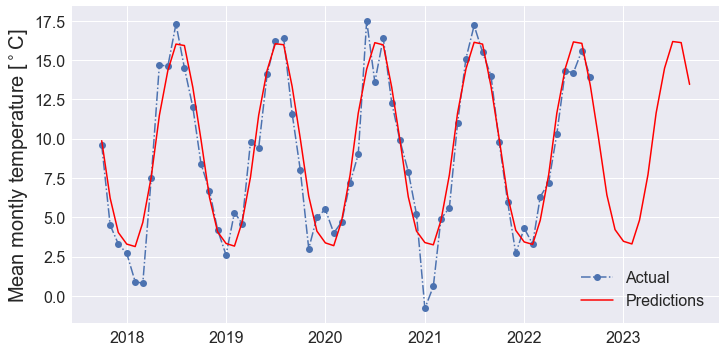

In [8]:
#visualize forecasted trend
#plot1 = m.plot(forecast[-72:], 
#               xlabel="Time",
#               ylabel="Mean monthly temperature [$^\circ$C]")
scale = -72
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(forecast["ds"][scale:], forecast["y"][scale:], label='Actual', linestyle='-.', marker='o')
plt.plot(forecast["ds"][scale:], forecast["yhat1"][scale:], label='Predictions', color='red')
ax.legend()#loc="lower right");
plt.ylabel("Mean montly temperature [$^\circ$C]")
plt.xlabel("")
plt.tight_layout()
plt.show()               
#plt.savefig("neuralprophet_future_forecast.pdf")

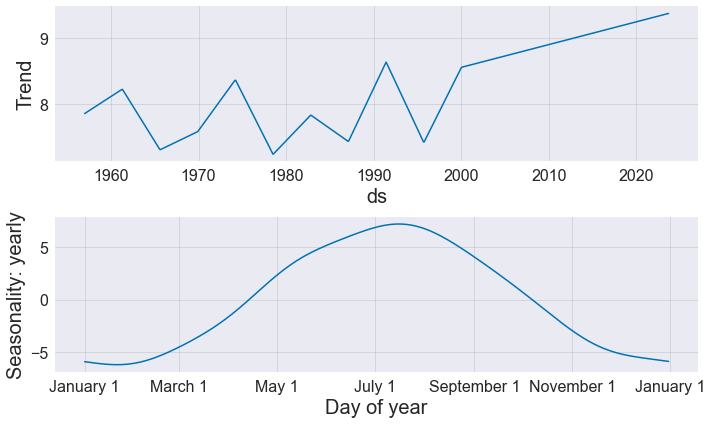

In [9]:
fig_comp = m.plot_components(forecast)
#fig, ax = plt.subplots(2, 1, figsize=(10, 5))
#ax[0].plot(forecast["ds"], forecast["trend"], label='Trend', linestyle='-.', marker='o')
#ax[1].plot(forecast["season_yearly"], label='Yearly seasonality', color='red')
#plt.ylabel("Mean montly temperature [$^\circ$C]")
#plt.xlabel("")
plt.tight_layout()
plt.show()
#plt.savefig("neuralprophet_forecast_components.pdf")

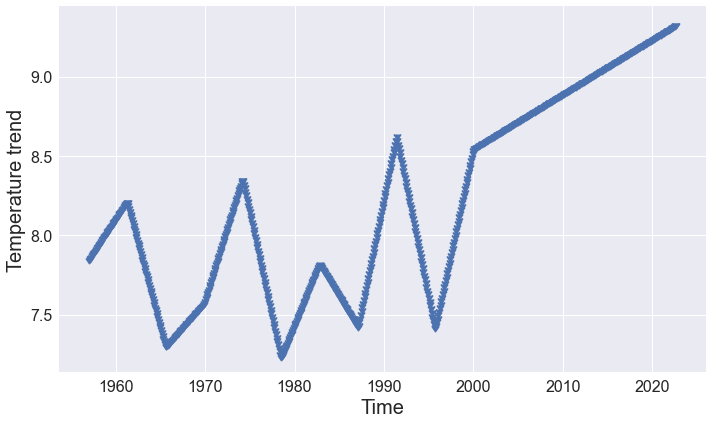

In [36]:
trendd = m.predict_trend(df2)
plt.scatter(x=trendd["ds"], y=trendd["trend"], label='Trend', marker=11)
plt.ylabel("Temperature trend")
plt.xlabel("Time")
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='ds', ylabel='yearly'>

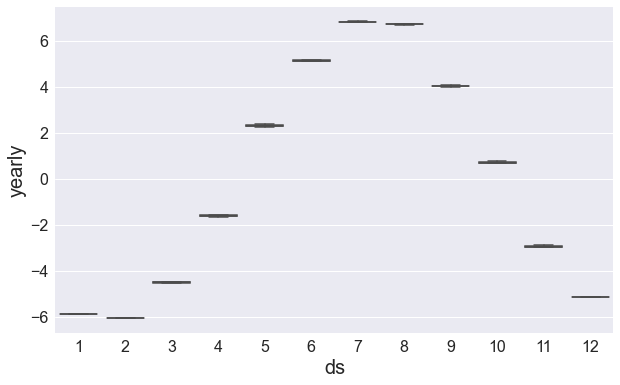

In [50]:
season = m.predict_seasonal_components(df2)
season.index = season["ds"]
season.index
#plt.plot(season["ds"], season["yearly"], label='Season-yearly')
sns.boxplot(x=season.index.month, y=season["yearly"], color="red")
# plt.ylabel("Temperature trend")
# plt.xlabel("Time")
# plt.tight_layout()
# plt.show()

In [ ]:
#plot metrics Mean Absolute Error for training and test sets
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(metrics["RMSE"], 'ob', linewidth=6, label="Training Loss")  
ax.plot(metrics["RMSE_val"], '-r', linewidth=2, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Prediction error")
plt.legend()
#plt.show()
# You can use metrics["SmoothL1Loss"] and metrics["SmoothL1Loss_val"] too.
#plt.savefig("neuralprophet_forecast_error_rmse.pdf")

In [ ]:
#plot metrics Mean Absolute Error for training and test sets
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(metrics["SmoothL1Loss"], 'ob', linewidth=6, label="Training Loss")  
ax.plot(metrics["SmoothL1Loss_val"], '-r', linewidth=2, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Huber Loss")
plt.legend()
plt.show()

##### NeuralProphet prediction for 2023

In [ ]:
#print forecast for 2023
#forecast[["ds", "yhat1"]].tail(12)
metrics.tail()

In [ ]:
forecast[-12:]

In [ ]:
#print forecast for 2023
plt.plot(forecast["ds"][-12:], forecast["yhat1"][-12:], linestyle='-.', marker='o')
plt.title("NeuralProphet predicted montly mean temperatures")
plt.xlabel("Time")
plt.ylabel("Predicted montly mean temperature [$^\circ$C]")
plt.tight_layout()
plt.show()

In [ ]:
forecast.tail(12)
#forecast[forecast.index > 788]["yhat1"] - forecast[forecast.index > 788]["residual1"]
#forecast[forecast.index > 788]["residual1"]
plt.plot(forecast["ds"], forecast["trend"], label='Trend')
#ax[1].plot(forecast["season_yearly"], label='Yearly seasonality', color='red')
plt.ylabel("Trend: Mean montly temperature [$^\circ$C]")
#plt.xlabel("")
plt.tight_layout()
plt.show()